# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [3]:
b = emcee.backends.HDFBackend('emulators/backends/eps_1.0000e-02_ntrain_500_fat_0.3.h5')

with open('emulators/emu_eps_1.0000e-02_ntrain_500_fat_0.3.pkl', 'rb') as f:
    emu = pickle.load(f)

In [4]:
emu._info['pc'].shape

(500, 95)

In [5]:
chain = b.get_chain()
lnp = b.get_log_prob()

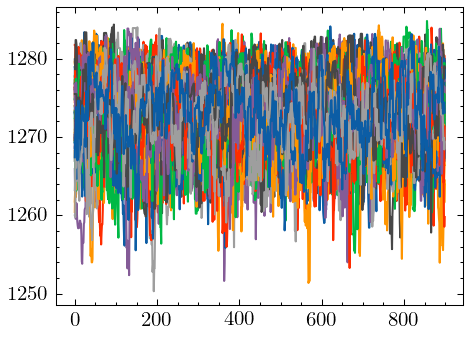

In [6]:
nb = 100
cutoff = -np.inf

ii = np.where(np.min(lnp[nb:, :], axis=0) > cutoff)[0]

plt.plot(lnp[nb:, ii]);

In [7]:
design_chain = np.load('datfiles/fat_0.3_posterior_chain.npy')

def plot_chain_summary(ch, ax):
    low, med, high = np.quantile(ch, [0.16, 0.5, 0.84])
    ax.axhspan(low, high, color='C1', alpha=0.5)
    ax.axhline(med, color='C1')

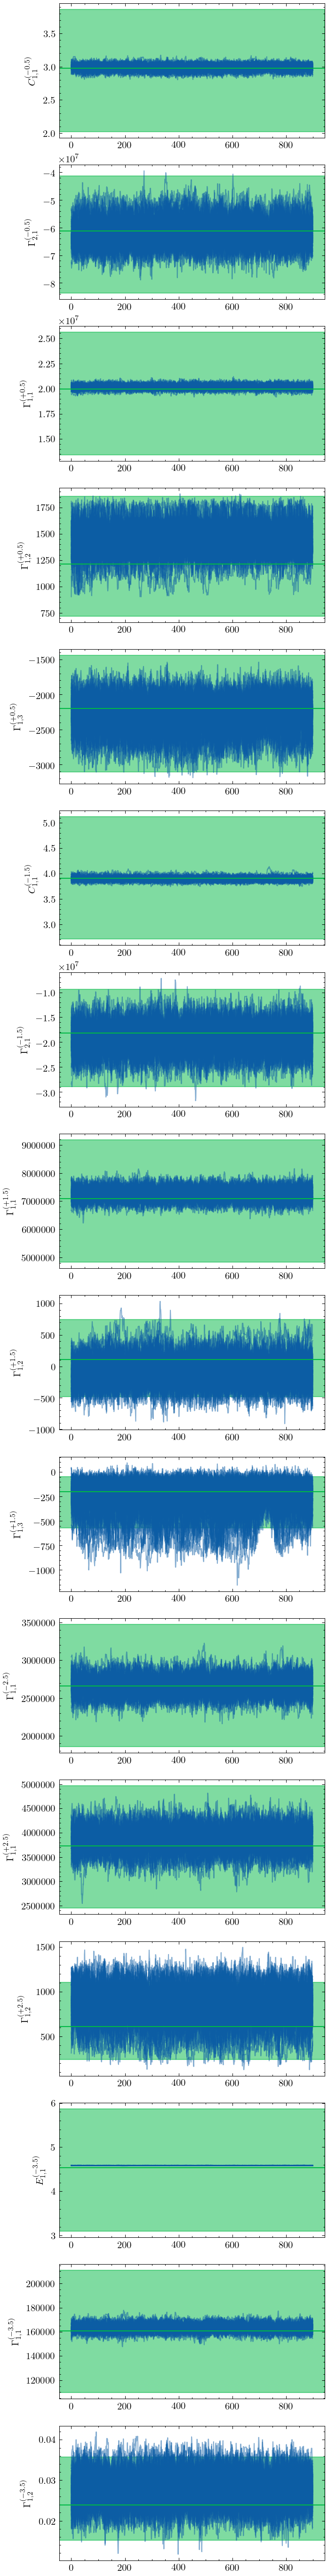

In [8]:
fig, ax = plt.subplots(model.nrpar, figsize=(gr*h, model.nrpar*h))
fig.patch.set_facecolor('white')

for i in range(model.nrpar):
    ax[i].plot(chain[nb:, ii, i], alpha=0.5, color='C0')
    ax[i].set_ylabel(model.azr.config.labels[i])
    plot_chain_summary(design_chain[:, i], ax[i])

In [9]:
# fig, ax = plt.subplots(model.nf_capture, 
#                        figsize=(gr*h, model.nf_capture*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar, model.nrpar + model.nf_capture)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [10]:
# fig, ax = plt.subplots(model.nf_scatter, 
#                        figsize=(gr*h, model.nf_scatter*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar + model.nf_capture, model.ndim)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [11]:
n1 = model.nbr
n2 = model.nxs

In [12]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [13]:
from multiprocessing import Pool
import os

In [14]:
os.environ['OMP_NUM_THREADS'] = '1'

In [15]:
_, _, nd = chain.shape
flat_chain_gp = chain[nb:, ii, :].reshape(-1, nd)
flat_chain_gp.shape

(57600, 32)

In [16]:
with Pool(processes=16) as pool:
    mus = pool.map(model.calculate, flat_chain_gp[::100, :])

In [17]:
mus_gp = emu.predict(theta=flat_chain_gp[::100, :16])

In [18]:
low_gp, high_gp = np.quantile(mus_gp.mean(), [0.16, 0.84], axis=1)
low, high = np.quantile(mus, [0.16, 0.84], axis=0)

In [19]:
def plot_bands(x, lb, ub, ax, color='C2', label=None):
    ii = np.argsort(x)
    ax.fill_between(x[ii], lb[ii], ub[ii],
                    color=color, alpha=0.75, label=label)

In [21]:
cp = np.load('/home/odell/7Be/CP/samples/sfactor.npy')

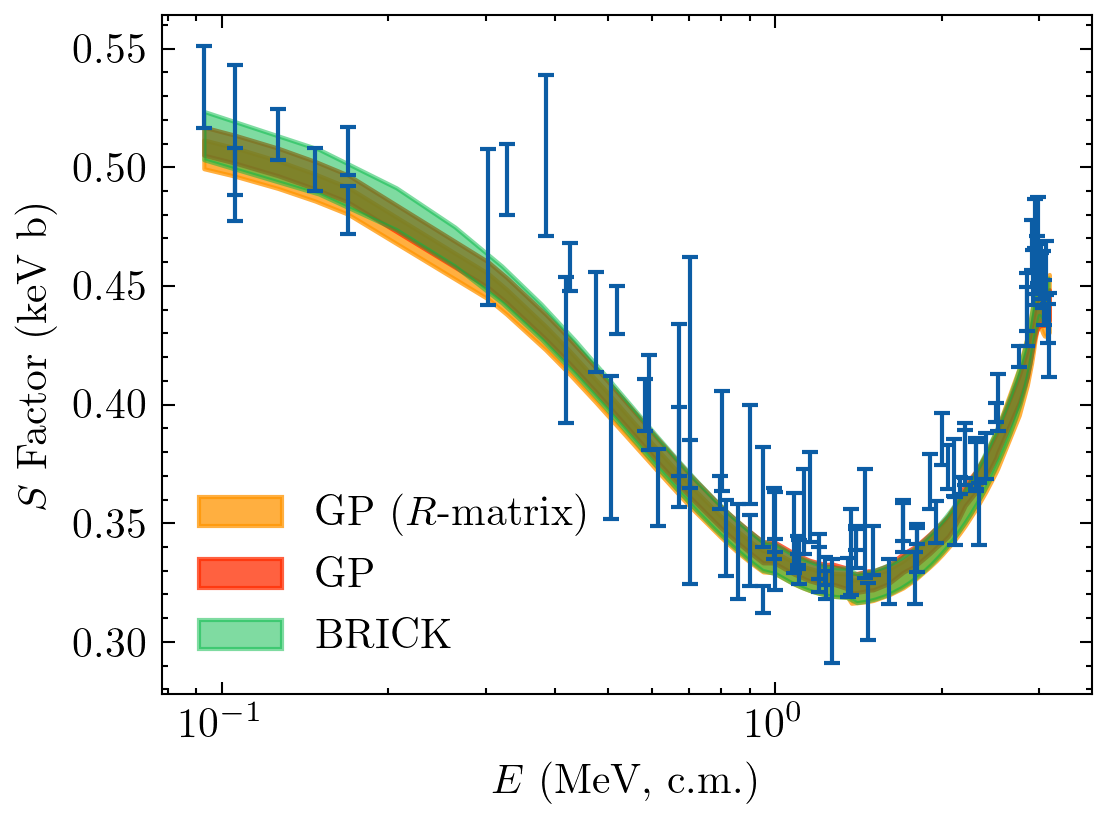

In [22]:
i = n1
j = n1+n2

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], 1000*model.y[n1:n1+n2], yerr=1000*model.dy[n1:n1+n2], linestyle='', capsize=2)

plot_bands(model.x[i:j], 1000*low[i:j], 1000*high[i:j], ax, label=r'GP ($R$-matrix)')
plot_bands(model.x[i:j], 1000*low_gp[i:j], 1000*high_gp[i:j], ax, color='C3', label=r'GP')

low_cs, high_cs = np.quantile(cp[:, :, 4], [0.16, 0.84], axis=0)
ax.fill_between(cp[0, :, 0], 1000*low_cs, 1000*high_cs, color='C1', label=r'BRICK', alpha=0.5)

ax.legend()
ax.set_ylabel('$S$ Factor (keV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_xscale('log');

In [24]:
def plot_band_width(x, lb, ub, ax, color='C2', label=None):
    ii = np.argsort(x)
    ax.plot(x[ii], ub[ii] - lb[ii], color=color, alpha=0.75, label=label)

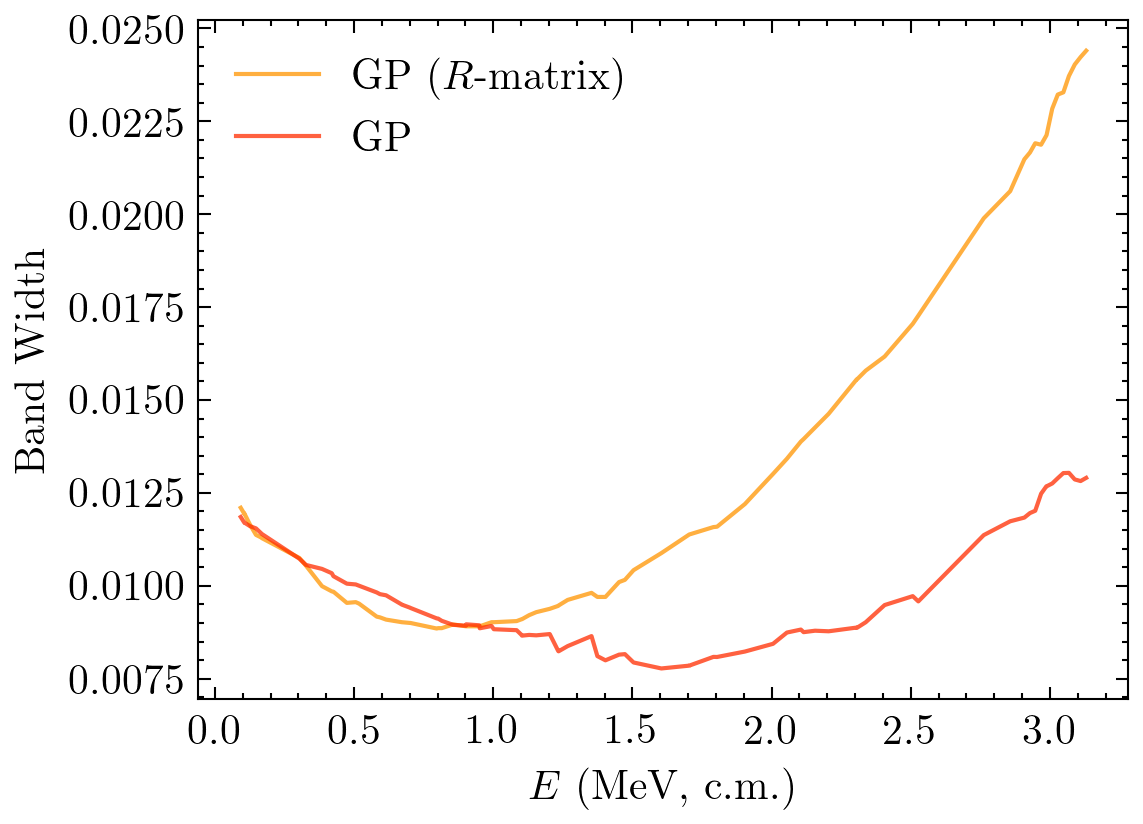

In [27]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
fig.patch.set_facecolor('white')

plot_band_width(model.x[i:j], 1000*low[i:j], 1000*high[i:j], ax, label=r'GP ($R$-matrix)')
plot_band_width(model.x[i:j], 1000*low_gp[i:j], 1000*high_gp[i:j], ax, color='C3', label=r'GP')

ax.legend()
ax.set_xlabel(r'$E$ (MeV, c.m.)')
ax.set_ylabel(r'Band Width');